# City blocks layer generating

In [1]:
import os
import geopandas as gpd

data_path = "./data"

In [2]:
boundaries = gpd.read_parquet(os.path.join(data_path, "boundaries.parquet"))
local_crs = boundaries.estimate_utm_crs()
boundaries = boundaries.to_crs(local_crs)
local_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## BlocksGenerator

In [3]:
from blocksnet import BlocksGenerator

water = gpd.read_parquet(os.path.join(data_path, "osm/water.parquet")).to_crs(local_crs)
roads = gpd.read_parquet(os.path.join(data_path, "osm/roads.parquet")).to_crs(local_crs)
railways = gpd.read_parquet(os.path.join(data_path, "osm/railways.parquet")).to_crs(local_crs)

bg = BlocksGenerator(boundaries=boundaries, water=water, roads=roads, railways=railways)

2024-09-16 22:01:51.739 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:99 - Check boundaries schema
2024-09-16 22:01:51.754 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:103 - Check roads schema
2024-09-16 22:01:51.775 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:109 - Check railways schema
2024-09-16 22:01:51.782 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:115 - Check water schema
2024-09-16 22:01:51.794 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:124 - Exclude water objects


In [4]:
blocks = bg.run()

2024-09-16 22:01:58.905 | INFO     | blocksnet.preprocessing.blocks_generator:run:161 - Generating blocks
2024-09-16 22:01:58.984 | INFO     | blocksnet.preprocessing.blocks_generator:run:170 - Setting up enclosures
2024-09-16 22:02:04.523 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Filling holes
2024-09-16 22:02:05.595 | INFO     | blocksnet.preprocessing.blocks_generator:run:178 - Dropping overlapping blocks
2024-09-16 22:02:07.691 | INFO     | blocksnet.preprocessing.blocks_generator:run:192 - Calculating blocks area
2024-09-16 22:02:07.821 | INFO     | blocksnet.preprocessing.blocks_generator:run:199 - Blocks generated


In [5]:
blocks.head()

,geometry
0,"POLYGON ((355560.390 6648337.904, 355563.648 6..."
1,"POLYGON ((355572.149 6648335.572, 355567.560 6..."
2,"POLYGON ((355572.149 6648335.572, 355583.354 6..."
3,"POLYGON ((355923.192 6648257.264, 355912.941 6..."
4,"POLYGON ((355923.192 6648257.264, 355930.255 6..."


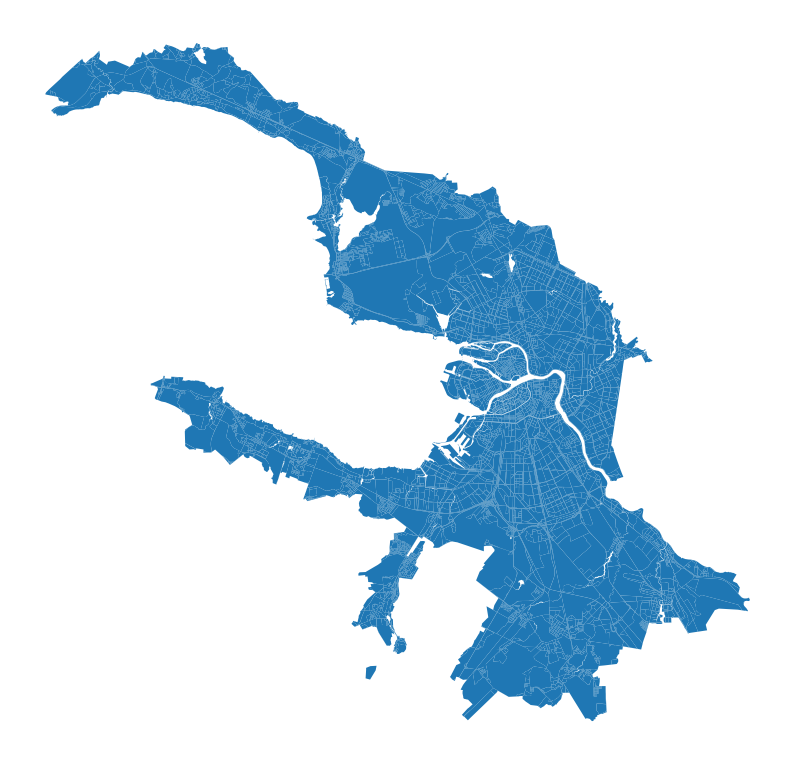

In [6]:
blocks.plot(figsize=(10,10)).set_axis_off()

## BlocksSplitter

In [51]:
from blocksnet import BlocksSplitter

buildings = gpd.read_parquet(os.path.join(data_path, 'buildings.parquet')).to_crs(local_crs)
buildings.geometry = buildings.representative_point()

bs = BlocksSplitter(blocks, buildings)

In [37]:
blocks = bs.run()
blocks

2024-07-18 13:49:28.761 | INFO     | blocksnet.preprocessing.blocks_splitter:run:164 - Joining buildings and blocks to exclude duplicates
2024-07-18 13:49:29.980 | INFO     | blocksnet.preprocessing.blocks_splitter:run:173 - Choosing blocks to be splitted
2024-07-18 13:49:30.393 | INFO     | blocksnet.preprocessing.blocks_splitter:run:182 - Splitting filtered blocks
 33%|███▎      | 83/250 [00:41<01:02,  2.66it/s]/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/shapely/constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
 40%|████      | 100/250 [00:48<01:20,  1.87it/s]/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/shapely/constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
 50%|█████     | 125/250 [00:55<00:33,  3.75it/s]/ho

,geometry
0,"POLYGON ((354918.622 6625258.829, 354901.464 6..."
1,"POLYGON ((355412.142 6623378.149, 355411.700 6..."
2,"POLYGON ((353934.329 6625429.433, 353923.453 6..."
3,"POLYGON ((355099.099 6623847.765, 355074.808 6..."
4,"POLYGON ((352766.168 6621954.748, 352744.412 6..."
...,...
16315,"POLYGON ((335210.252 6655823.328, 335105.217 6..."
16316,"POLYGON ((315582.435 6679561.357, 315523.467 6..."
16317,"POLYGON ((316419.909 6679189.653, 316319.749 6..."
16318,"POLYGON ((315709.232 6679519.841, 315748.877 6..."


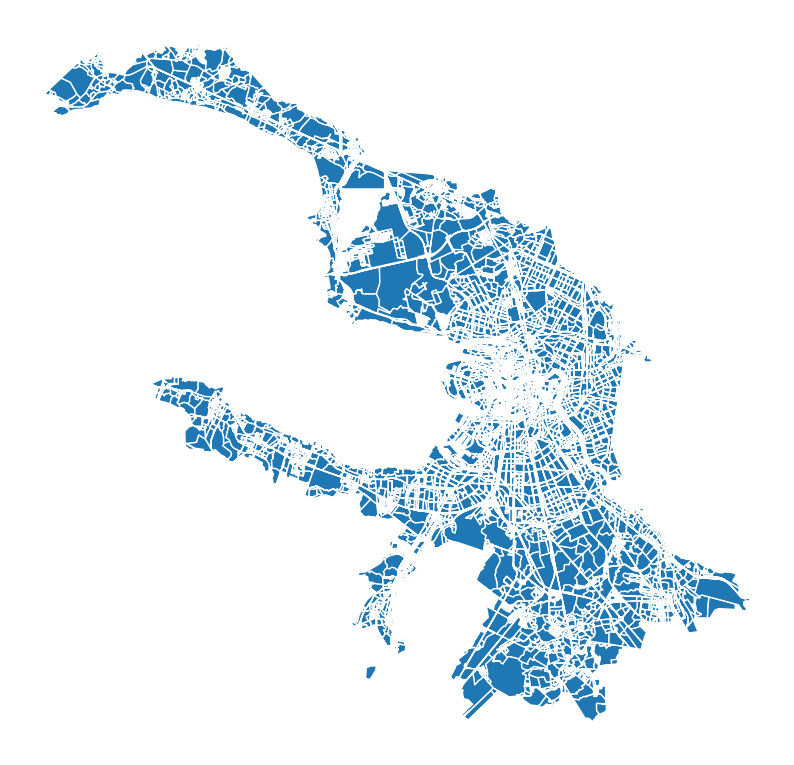

In [38]:
blocks.plot(figsize=(10,10)).set_axis_off()

## LandUseProcessor

In [52]:
from blocksnet import LandUseProcessor

zones = gpd.read_parquet(os.path.join(data_path, "zones.parquet")).to_crs(local_crs)
lup = LandUseProcessor(blocks=blocks, zones=zones)

In [53]:
blocks = lup.run()

2024-07-18 13:55:56.345 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:183 - Overlaying geometries
2024-07-18 13:56:06.119 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:196 - Finding sum of intersection areas
2024-07-18 13:56:06.176 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:208 - Getting intersecting attributes


Save the result for the next example

In [54]:
blocks.head()

,geometry,zone,land_use
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",NaN,None
1,"POLYGON ((355412.142 6623378.149, 355411.700 6...",ТИ3,TRANSPORT
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",ТР2,RECREATION
3,"POLYGON ((355099.099 6623847.765, 355074.808 6...",Т3Ж1,RESIDENTIAL
4,"POLYGON ((352766.168 6621954.748, 352744.412 6...",ТР4,RECREATION


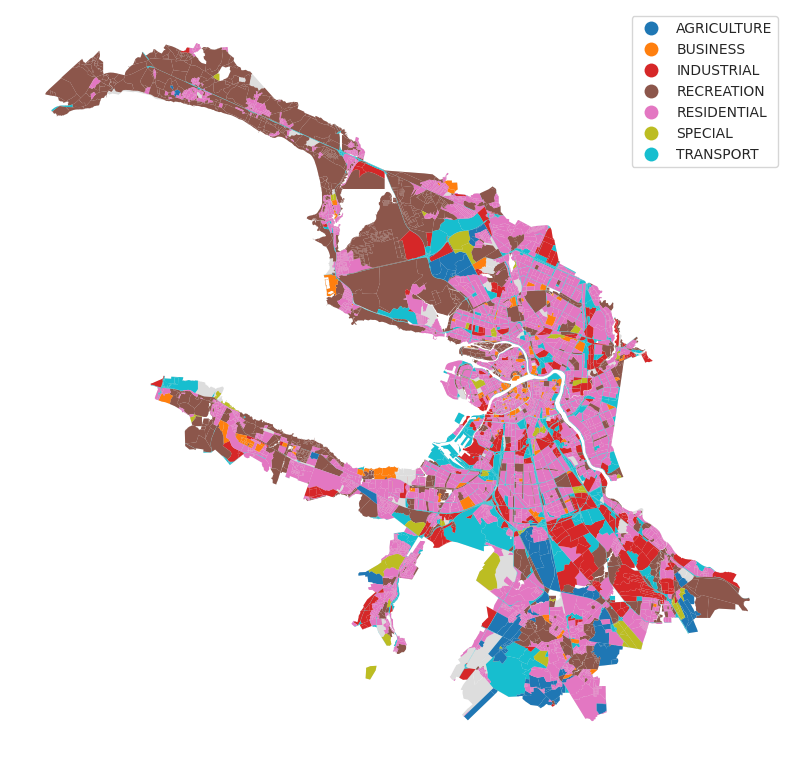

In [55]:
ax = blocks.plot(color='#ddd', figsize=(10,10), linewidth=0)
blocks.plot(column='land_use', legend=True, ax=ax, linewidth=0).set_axis_off()

## Saving the results

In [56]:
blocks.to_parquet(os.path.join(data_path, "blocks.parquet"))